In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Collaborative Filtering is being used to predict places based on the user's history of ratings by taking user id as input. This is Only for places which are not already visited or rated by the user.

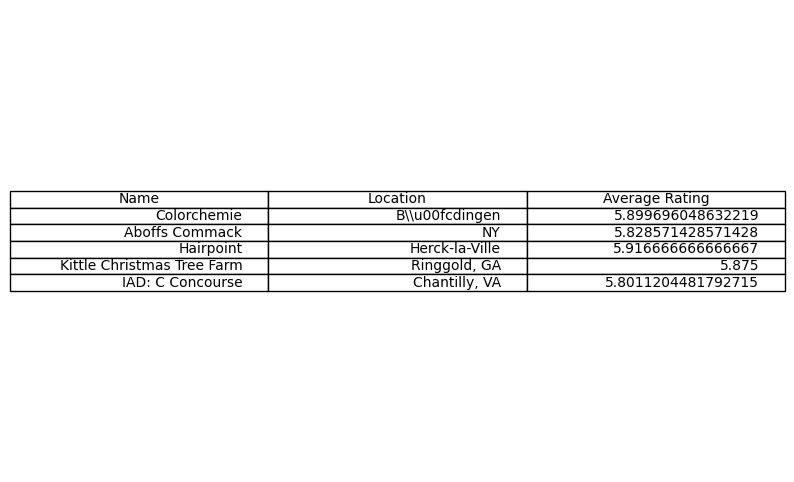

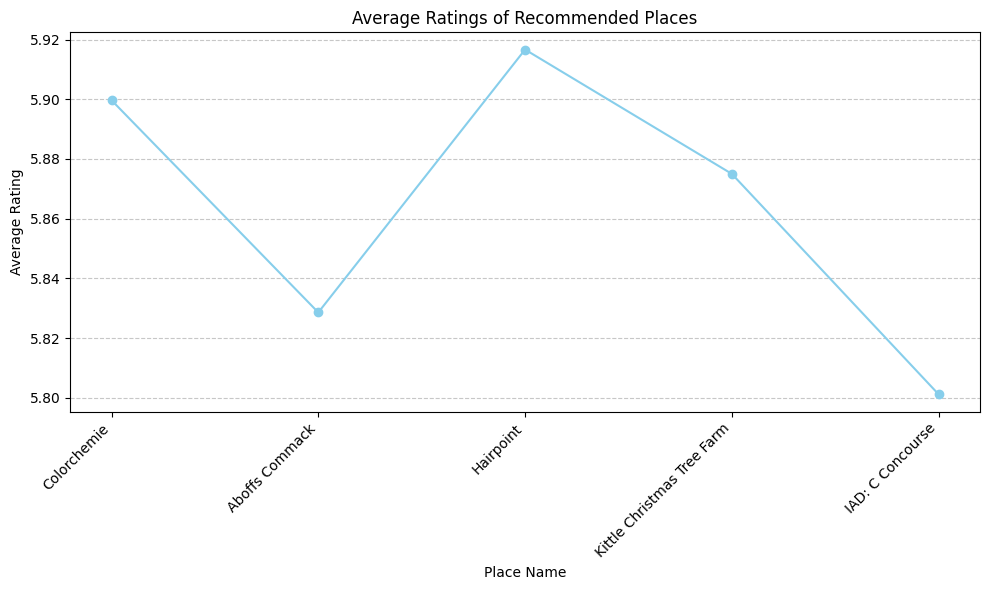

In [3]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

rating = pd.read_csv('/content/drive/My Drive/checkins.csv')
places = pd.read_csv('/content/drive/My Drive/spots_subset2.csv', encoding='latin-1')

Rating_matrix = rating.pivot_table(columns='place_id', index='user_id', values='ratings').fillna(rating['ratings'].mean()).values
Rating_table = rating.pivot_table(columns='place_id', index='user_id', values='ratings')
Rating_table = Rating_table.fillna(Rating_table.mean())
Rating_matrix = Rating_table.values

u, s, v = svds(Rating_matrix, k=30)
s = np.diag(s)

pred_ratings = np.dot(np.dot(u, s), v)
preds = pd.DataFrame(pred_ratings, columns=Rating_table.columns)

def predict(user_id, no_of_sugg, preds, rating, movie):
    x = preds.iloc[user_id].sort_values(ascending=False)
    not_repeated_mask = ~x.index.isin(rating.loc[(rating['user_id'] == user_id + 1), 'place_id'])
    x = x[not_repeated_mask]

    recommendations = []
    ratings_table = pd.DataFrame(columns=['Name', 'Location', 'Average Rating'])
    for place_id in x.index[:no_of_sugg]:
        place_info = movie[movie['place_id'] == place_id]
        name = place_info['name'].values[0]
        location = place_info['location'].values[0]
        avg_rating = rating[rating['place_id'] == place_id]['ratings'].mean()
        recommendations.append((name, location, avg_rating))
        ratings_table = pd.concat([ratings_table, pd.DataFrame({'Name': [name], 'Location': [location], 'Average Rating': [avg_rating]})], ignore_index=True)

    output = pd.DataFrame(recommendations, columns=['Name', 'Location', 'Average Rating'])
    return output, ratings_table

result_recommendations, result_ratings_table = predict(58, 5, preds, rating, places)

# Plotting the ratings table
plt.figure(figsize=(10, 6))
plt.table(cellText=result_ratings_table.values, colLabels=result_ratings_table.columns, loc='center')
plt.axis('off')
plt.show()

# Calculate frequency of different rating ranges
rating_counts = result_ratings_table['Average Rating'].value_counts().sort_index()

# Plotting a line graph for average ratings
plt.figure(figsize=(10, 6))
plt.plot(result_ratings_table['Name'], result_ratings_table['Average Rating'], marker='o', color='skyblue', linestyle='-')
plt.title('Average Ratings of Recommended Places')
plt.xlabel('Place Name')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


